In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.losses import Huber
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.models import Sequential as sq
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Bidirectional, Dropout

In [ ]:
data = pd.read_csv('weather_features.csv',)
data = data[['dt_iso', 'temp']]
data

,dt_iso,temp
0,2015-01-01 00:00:00+01:00,270.475
1,2015-01-01 01:00:00+01:00,270.475
2,2015-01-01 02:00:00+01:00,269.686
3,2015-01-01 03:00:00+01:00,269.686
4,2015-01-01 04:00:00+01:00,269.686
...,...,...
178391,2018-12-31 19:00:00+01:00,287.760
178392,2018-12-31 20:00:00+01:00,285.760
178393,2018-12-31 21:00:00+01:00,285.150
178394,2018-12-31 22:00:00+01:00,284.150


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt_iso  178396 non-null  object 
 1   temp    178396 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.7+ MB


In [ ]:
data.isna().sum()

dt_iso    0
temp      0
dtype: int64

In [ ]:
data['dt_iso'] = pd.to_datetime(data['dt_iso'])

In [ ]:
dates = data['dt_iso'].values
temp = data['temp'].values

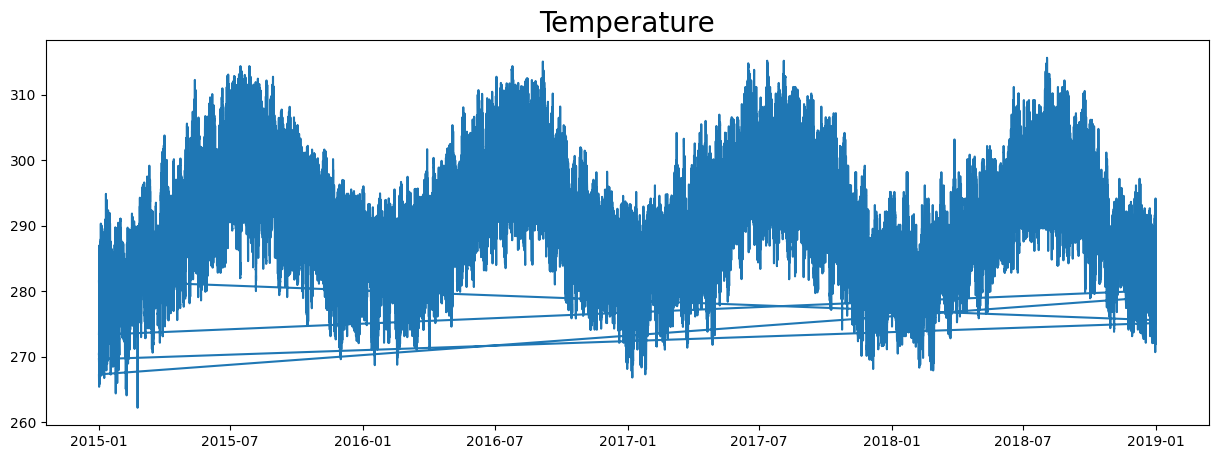

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dates, temp)
plt.title('Temperature',
          fontsize=20);

In [ ]:
scl = MinMaxScaler()

data_scale = scl.fit_transform(temp.reshape(-1, 1))

In [ ]:
threshold_mae = (data_scale.max() - data_scale.min()) * 10/100

print(threshold_mae)

0.1


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffle):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))

  ds = ds.shuffle(shuffle_buffle)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_scale, dates, test_size=0.2, shuffle=False)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffle=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffle=1000)

print(train_set.element_spec)

(TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None))


In [ ]:
model = tf.keras.models.Sequential([
    LSTM(60, return_sequences=True, input_shape = (None, 1)),
    LSTM(30),
    Dropout(0.15),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(optimizer = SGD(learning_rate = 1.0000e-04, momentum=0.9),
              loss = Huber(),
              metrics = ['mae'])

In [ ]:
class mycallback(Callback):

  def on_epoch_end(self, epochs, logs=None):
    mae = logs.get('mae')
    if mae < threshold_mae:
      self.model.stop_training = True

In [ ]:
history = model.fit(train_set,
                    validation_data = (test_set),
                    epochs = 100,
                    callbacks=mycallback())

Epoch 1/100
1427/1427 [==============================] - 43s 28ms/step - loss: 0.0254 - mae: 0.1689 - val_loss: 0.0112 - val_mae: 0.1173
Epoch 2/100
1427/1427 [==============================] - 44s 31ms/step - loss: 0.0094 - mae: 0.1113 - val_loss: 0.0106 - val_mae: 0.1146
Epoch 3/100
1427/1427 [==============================] - 43s 30ms/step - loss: 0.0092 - mae: 0.1101 - val_loss: 0.0105 - val_mae: 0.1135
Epoch 4/100
1427/1427 [==============================] - 42s 29ms/step - loss: 0.0091 - mae: 0.1093 - val_loss: 0.0103 - val_mae: 0.1127
Epoch 5/100
1427/1427 [==============================] - 42s 29ms/step - loss: 0.0090 - mae: 0.1083 - val_loss: 0.0101 - val_mae: 0.1117
Epoch 6/100
1427/1427 [==============================] - 42s 29ms/step - loss: 0.0089 - mae: 0.1075 - val_loss: 0.0099 - val_mae: 0.1106
Epoch 7/100
1427/1427 [==============================] - 43s 30ms/step - loss: 0.0088 - mae: 0.1068 - val_loss: 0.0098 - val_mae: 0.1100
Epoch 8/100
1427/1427 [==================

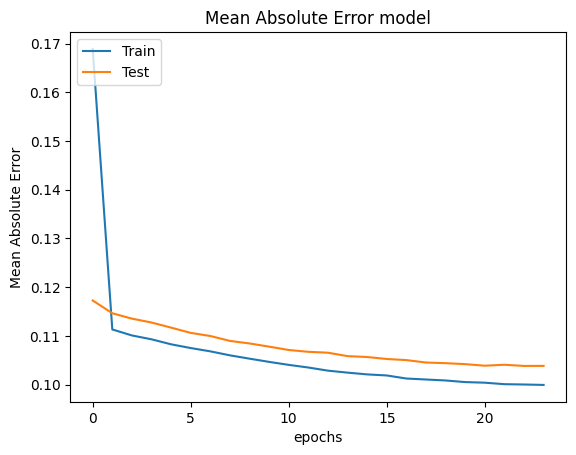

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error model')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

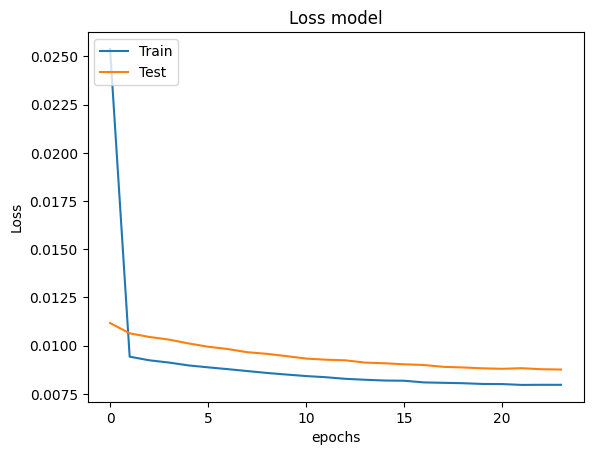

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss model')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()